In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
from pathlib import Path
import pandas as pd
from scipy import stats
from tensorflow.keras import preprocessing
rng = np.random.RandomState(42)
covid_datasets_dir = Path('covid-datasets')
print('Loaded!')

Loaded!


Total COVID-19 Images: 526
Total COVID-19 X-Rays: 446
Total Unique Patient COVID-19 X-Rays: 259
Total Unique Patient COVID-19 PA, AP, or AP Supine X-Rays: 259


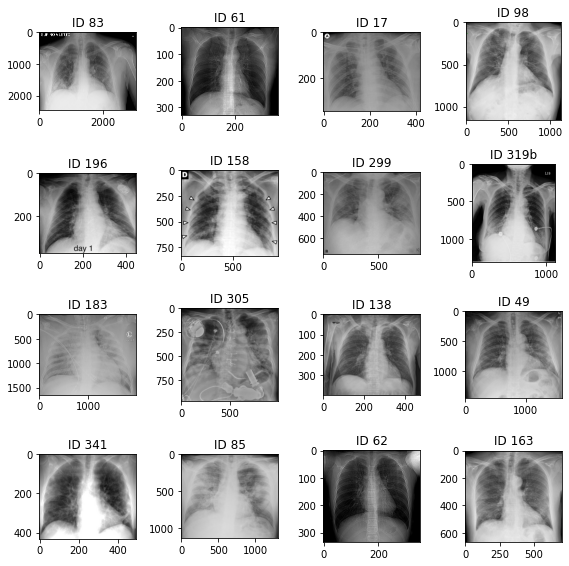

In [7]:
# filtering out unimportant data
cohen_covid_md = pd.read_csv(str(Path('covid-datasets/covid-chestxray-dataset/metadata.csv')))
# Removes all non-covid data from dataframe
cohen_covid_md = cohen_covid_md[(cohen_covid_md['finding'] == 'COVID-19')]
print(f'Total COVID-19 Images: {cohen_covid_md.shape[0]}')
# Removes all non-X-Ray data from dataframe
cohen_covid_md = cohen_covid_md[(cohen_covid_md['modality'] == 'X-ray')]
print(f'Total COVID-19 X-Rays: {cohen_covid_md.shape[0]}')
# Drops all duplicated patient X-rays except for the first X-ray (earliest offset)
cohen_covid_md = cohen_covid_md.drop_duplicates('patientid', keep='first')
print(f'Total Unique Patient COVID-19 X-Rays: {cohen_covid_md.shape[0]}')
# Removes all Lateral X-rays (keeps only PA or AP images)
cohen_covid_md = cohen_covid_md[cohen_covid_md['view'].isin(['PA', 'AP', 'AP Supine'])]
print(f'Total Unique Patient COVID-19 PA, AP, or AP Supine X-Rays: {cohen_covid_md.shape[0]}')
cohen_image_dir = covid_datasets_dir / 'covid-chestxray-dataset' / 'images'
# gets a list of all .png and .jpg images in cohen dataset
# cohen_image_paths = sorted(list(cohen_image_paths.glob('**/*.png')) + list(cohen_image_paths.glob('**/*.jpg')))
sqrt_n_samples = 4
fig, axes = plt.subplots(nrows=sqrt_n_samples, ncols=sqrt_n_samples, figsize=(8,8))
xray_samples = cohen_covid_md.sample(n=sqrt_n_samples**2, random_state=rng, axis=0)
for ax, xray_sample in zip(axes.ravel(), xray_samples.iterrows()):
    xray_sample = xray_sample[1]
    image = plt.imread(str(cohen_image_dir / xray_sample['filename']))
    ax.imshow(image, cmap='gray')
    ax.set_title(f"ID {xray_sample['patientid']}")
plt.tight_layout()
plt.show()

# Image Preprocessing

1. Interpolation to same size
2. Percentile cropping
3. Intensity normalisation

...Interpretability Techniques for COVID-19 paper


-- OR --

1. Histogram equalization
2. Lung segmentation (extracting the lungs from the image and only using the extraction)

... Unveiling COVID-19 paper


In [13]:
cohen_covid_md['filename']


0      auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
4                                  nejmc2001573_f1a.jpeg
7                                      lancet-case2a.jpg
20                  1-s2.0-S0140673620303706-fx1_lrg.jpg
21                 nCoV-radiol.2020200269.fig1-day7.jpeg
                             ...                        
664                            covid-19-caso-91-1-12.png
666                            covid-19-caso-94-1-14.png
667                            covid-19-caso-95-1-15.png
671                            covid-19-caso-99-1-19.png
672                           covid-19-caso-111-1-21.png
Name: filename, Length: 259, dtype: object

In [22]:
IDG = preprocessing.image.ImageDataGenerator()

In [25]:
test = IDG.flow_from_dataframe(
    dataframe=cohen_covid_md,
    directory=cohen_image_dir,
    x_col='filename',
    y_col='finding',
    target_size = (512, 512),
    color_mode='grayscale',
    batch_size=1,
    seed=42,
    save_to_dir=covid_datasets_dir / 'test-preprocessing',
    interpolation='bicubic'
)

Found 259 validated image filenames belonging to 1 classes.


In [32]:
x,y = test.next
x

259